In [238]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
from config import api_key
import requests
import json
from datetime import datetime

In [239]:
tickers = ["AAPL", "GOOG", "AMZN"]

dummy = pd.DataFrame(columns = ["ticker", "o", "c", "t"])

#create loop to run through URL & save info into lists
for name in tickers:
    base_url = f"https://api.polygon.io/v2/aggs/ticker/{name}/range/1/day/2012-01-01/2022-10-24?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    response = requests.get(base_url).json()
    datadata = pd.json_normalize(response["results"])
    datadata["ticker"] = name
    datadata = datadata[["ticker", "o", "c", "t"]]

#print(datadata)
    dummy = pd.concat([dummy,datadata])
dummy.columns=["ticker", "open", "close", "date"]

#pd.concat([dummy,datadata],axis=0)
print(dummy.head())


  ticker     open    close           date
0   AAPL  21.2457  21.2614  1351656000000
1   AAPL  21.3650  21.3050  1351742400000
2   AAPL  21.2818  20.6000  1351828800000
3   AAPL  20.8398  20.8793  1352091600000
4   AAPL  21.0796  20.8161  1352178000000


In [240]:
#Print types
#dummy.info()
#Convert unix to datetime & remove hours/miuntes
dummy['date'] = pd.to_datetime(dummy['date'],unit='ms')
dummy["date"] = pd.to_datetime(dummy["date"]).dt.date
#dummy.head()

In [241]:
#Create copy of dummy
tickers_copy = dummy.copy(deep=True)
#delete
del tickers_copy["open"]
#tickers_copy
#Create copy of dummy for %change & $change
tickers_pctchange = tickers_copy.copy(deep=True)


#Divide dataframes into new dataframes by ticker
aapl_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AAPL"]
aapl_daily2 = pd.DataFrame(aapl_daily2)
#print(aapl_daily2.head())
amzn_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AMZN"]
amzn_daily2 = pd.DataFrame(amzn_daily2)
#print(amzn_daily2.head())
goog_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "GOOG"]
goog_daily2 = pd.DataFrame(goog_daily2)
#print(goog_daily2.head())

#rename close as ticker to prepare to merge by date
aapl_daily2.rename(columns = {'close':'AAPL'}, inplace = True)
del aapl_daily2["ticker"]
amzn_daily2.rename(columns = {'close':'AMZN'}, inplace = True)
del amzn_daily2["ticker"]
goog_daily2.rename(columns = {'close':'GOOG'}, inplace = True)
del goog_daily2["ticker"]

#make copy for prices 
aapl_prices = aapl_daily2.copy(deep=True)
amzn_prices = amzn_daily2.copy(deep=True)
goog_prices = goog_daily2.copy(deep=True)
#print(aapl_prices)

#make copy for $ changes
aapl_bch = aapl_daily2.copy(deep=True)
amzn_bch = amzn_daily2.copy(deep=True)
goog_bch = goog_daily2.copy(deep=True)
#print(goog_bch)

#calculate % change
aapl_daily2["AAPL"]=aapl_daily2["AAPL"].pct_change()*100
amzn_daily2["AMZN"]=amzn_daily2["AMZN"].pct_change()*100
goog_daily2["GOOG"]=goog_daily2["GOOG"].pct_change()*100
aapl_daily2 = aapl_daily2[["date", "AAPL"]]

#calculate $ change
aapl_bch["AAPL"]=aapl_bch["AAPL"].diff()
amzn_bch["AMZN"]=amzn_bch["AMZN"].diff()
goog_bch["GOOG"]=goog_bch["GOOG"].diff()
#amzn_bch.head()
#aapl_daily2

In [242]:
#merge tables % change
merge_pctchange = aapl_daily2.merge(amzn_daily2, on='date', how='left')
merge_pctchange = merge_pctchange.merge(goog_daily2, on="date", how="left")
#merge_pctchange.head()

#merge tables prices 
merge_prices = aapl_prices.merge(amzn_prices, on='date', how='left')
merge_prices = merge_prices.merge(goog_prices, on="date", how="left")

#merge tables $change
merge_bch = aapl_bch.merge(amzn_bch, on='date', how='left')
merge_bch = merge_bch.merge(goog_bch, on="date", how="left")
merge_bch.head()

#reorder columns
merge_pctchange= merge_pctchange[['date','AAPL','GOOG', "AMZN"]]
merge_prices= merge_prices[['date','AAPL','GOOG', "AMZN"]]
merge_bch= merge_bch[['date','AAPL','GOOG', "AMZN"]]
#merge_bch
#merge_pctchange
#aapl_bch.head()

In [316]:

#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure(figsize=(100,200))
gs=plt.GridSpec(32,4, hspace=0.8, wspace = 0.3)
plt.rc('xtick', labelsize=70)
plt.rc('ytick', labelsize=70) 
#AAPL subplots

ax_aapl_bar_z=fig.add_subplot(gs[0:4, 0:4])
ax_aapl_bar_z.bar(aapl_bch["date"], aapl_bch["AAPL"], align='center')
ax_hist_aapl_y=fig.add_subplot(gs[4:7,0:3],  sharey=ax_hist_aapl_y)
ax_hist_aapl_y.hist(aapl_prices["AAPL"])
ax_scatter_aapl=fig.add_subplot(gs[7:11, 0:3])
ax_scatter_aapl.scatter(aapl_daily2["date"], aapl_daily2["AAPL"])
ax_hist_aapl_x=fig.add_subplot(gs[7:11,3])
ax_hist_aapl_x.hist(aapl_daily2["AAPL"], orientation="horizontal")
#add AMZN subplots
ax_amzn_bar=fig.add_subplot(gs[11:15, 0:4])
ax_amzn_bar.bar(amzn_bch["date"], amzn_bch["AMZN"], align='center')
ax_hist_amzn_y=fig.add_subplot(gs[15:18,0:3])
ax_hist_amzn_y.hist(amzn_prices["AMZN"])
ax_scatter_amzn=fig.add_subplot(gs[18:22, 0:3])
ax_scatter_amzn.scatter(amzn_daily2["date"], amzn_daily2["AMZN"])
ax_hist_amzn_x=fig.add_subplot(gs[18:22,3])
ax_hist_amzn_x.hist(amzn_daily2["AMZN"], orientation="horizontal")
#add GOOGL subplots
ax_goog_bar=fig.add_subplot(gs[22:26, 0:4])
ax_goog_bar.bar(goog_bch["date"], goog_bch["GOOG"], align='center')
ax_hist_goog_y=fig.add_subplot(gs[26:29,0:3])
ax_hist_goog_y.hist(goog_prices["GOOG"])
ax_scatter_goog=fig.add_subplot(gs[29:33, 0:3])
ax_scatter_goog.scatter(goog_daily2["date"], goog_daily2["GOOG"])
ax_hist_goog_x=fig.add_subplot(gs[29:33,3])
ax_hist_goog_x.hist(goog_daily2["GOOG"], 40,orientation="horizontal")
plt.show()

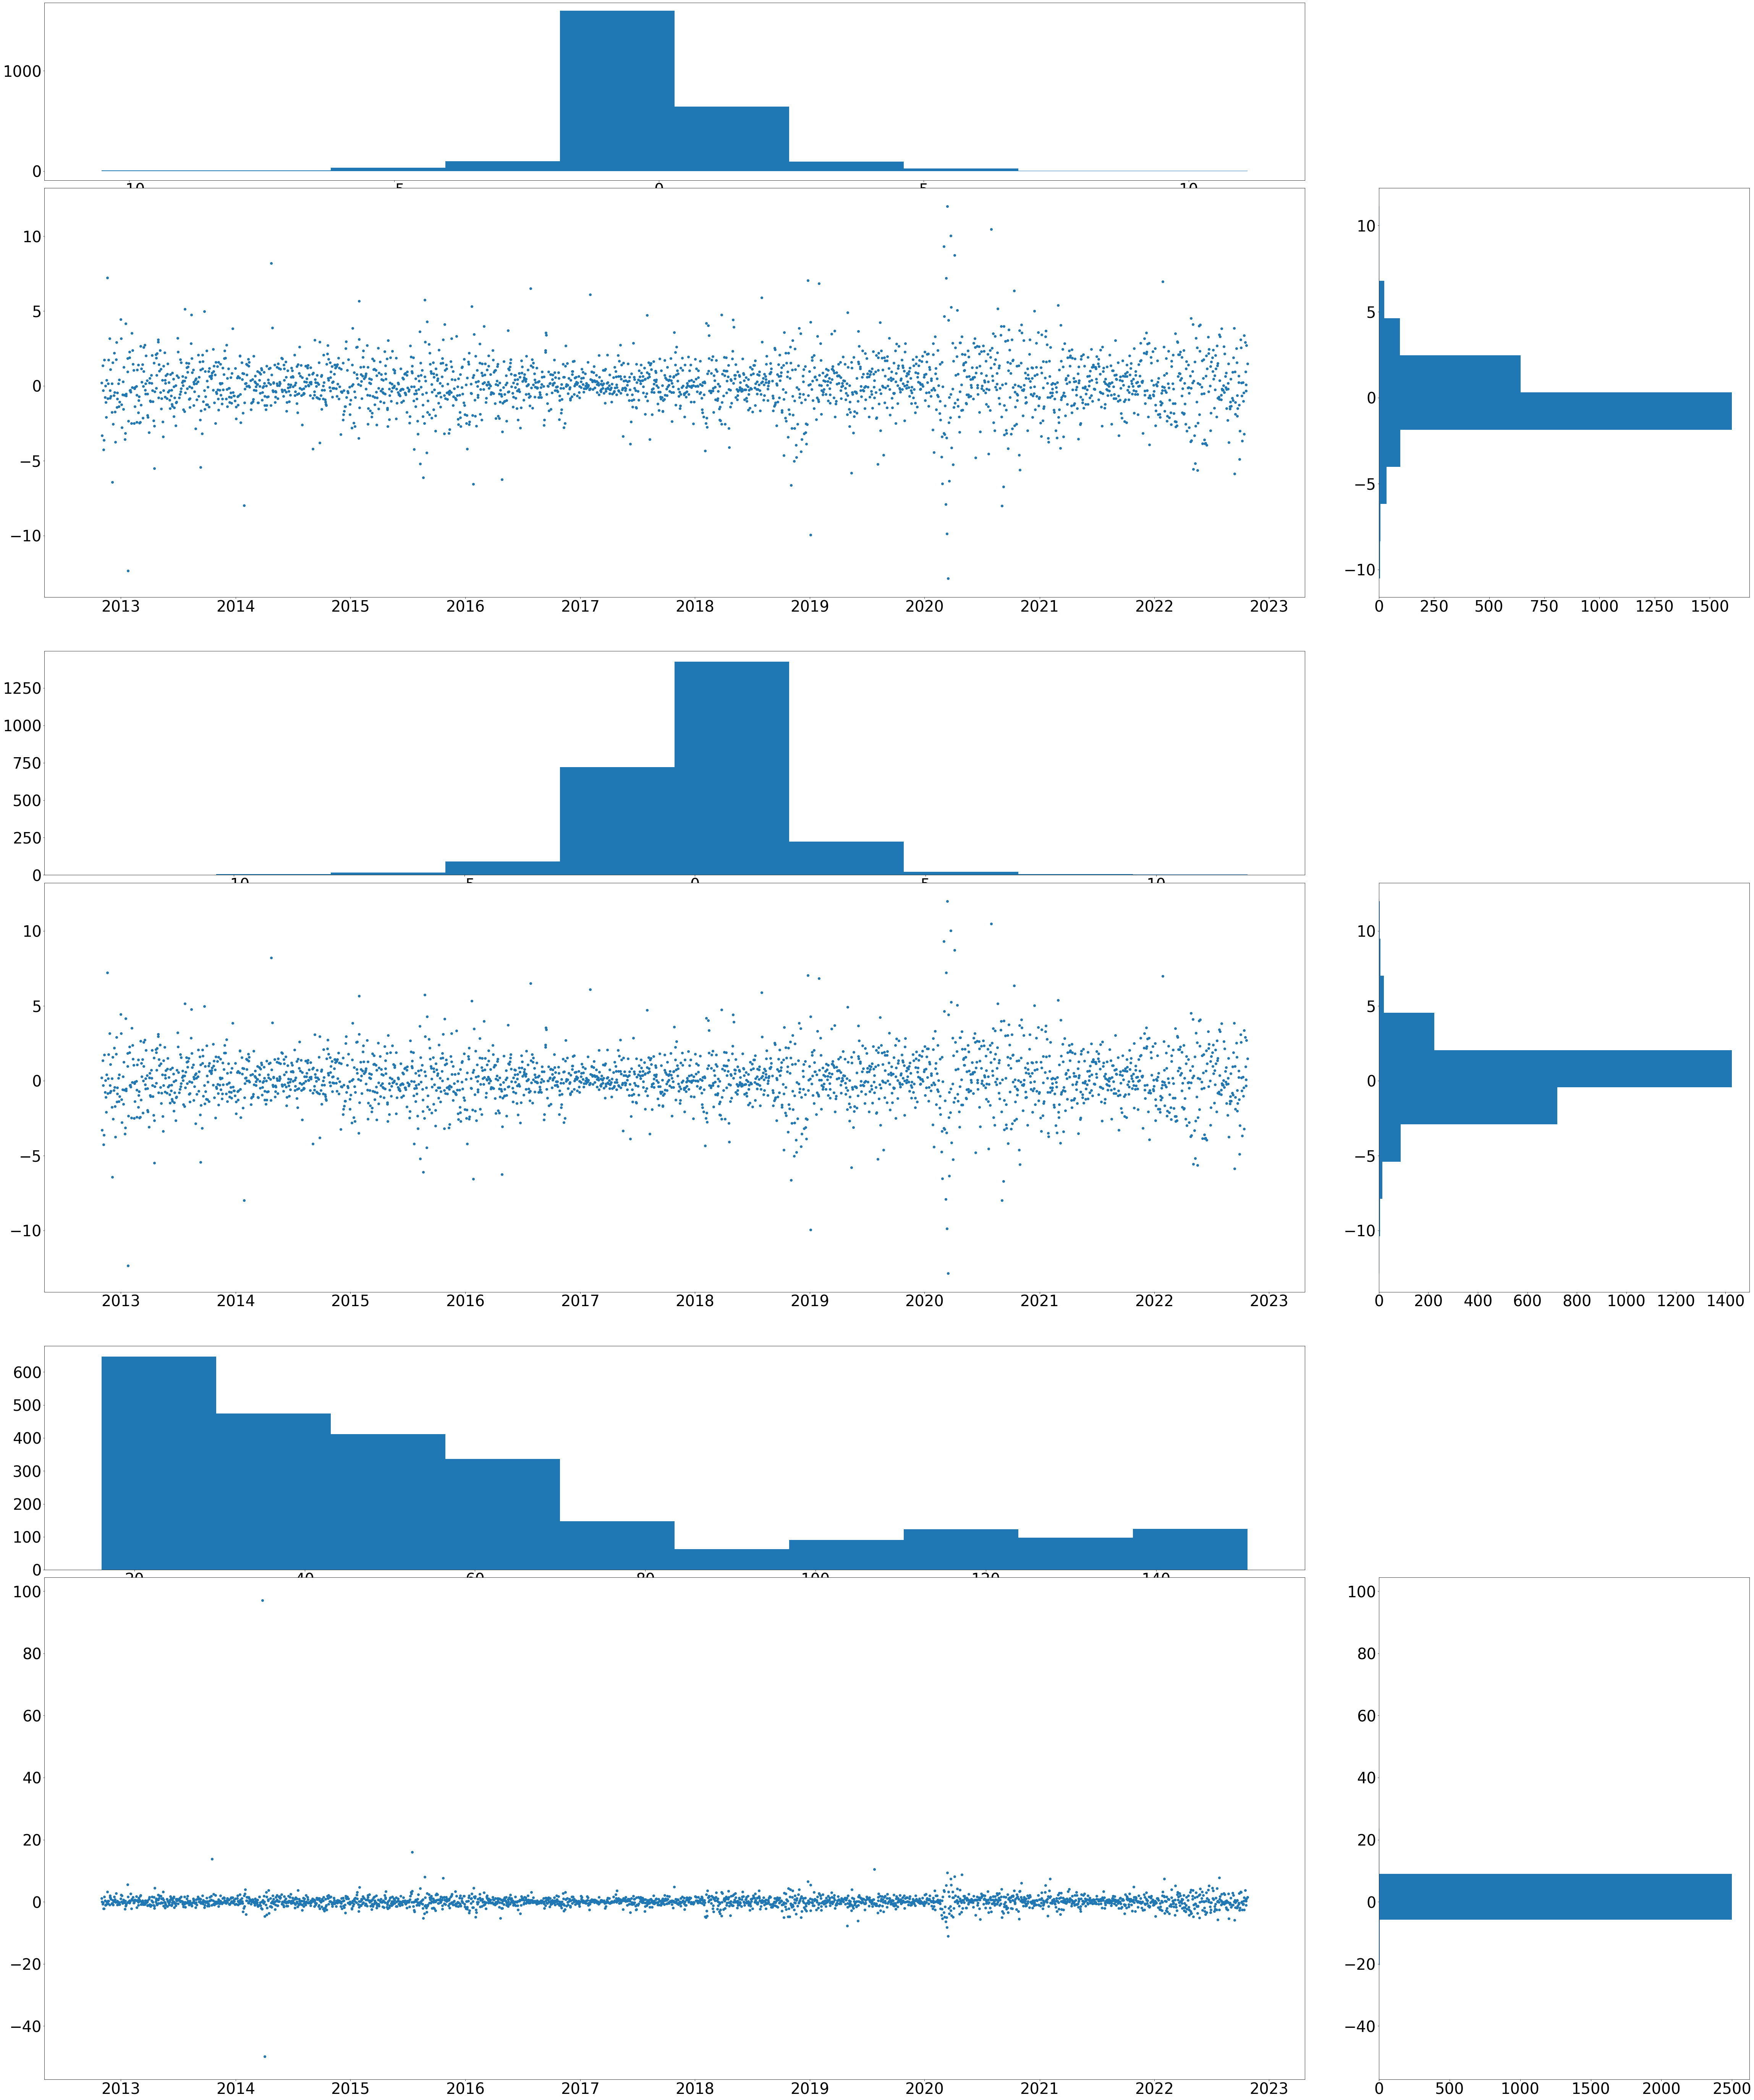

In [318]:
#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure(figsize=(80,100))
gs=plt.GridSpec(45,4,hspace=0.2, wspace=0.2)
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40) 
#AAPL subplots
ax_hist_aapl_y=fig.add_subplot(gs[0:4,0:3],  sharey=ax_hist_aapl_y)
ax_hist_aapl_y.hist(aapl_bch["AAPL"])

ax_scatter_aapl=fig.add_subplot(gs[4:13, 0:3])
ax_scatter_aapl.scatter(aapl_bch["date"], aapl_daily2["AAPL"])
ax_hist_aapl_x=fig.add_subplot(gs[4:13,3])
ax_hist_aapl_x.hist(aapl_bch["AAPL"], orientation="horizontal")
#add AMZN subplots
ax_hist_amzn_y=fig.add_subplot(gs[14:19,0:3])
ax_hist_amzn_y.hist(aapl_daily2["AAPL"])
ax_scatter_amzn=fig.add_subplot(gs[19:28, 0:3])
ax_scatter_amzn.scatter(aapl_daily2["date"], aapl_daily2["AAPL"])
ax_hist_amzn_x=fig.add_subplot(gs[19:28,3])
ax_hist_amzn_x.hist(aapl_daily2["AAPL"], orientation="horizontal")
#add GOOGL subplots

ax_hist_goog_y=fig.add_subplot(gs[29:34,0:3])
ax_hist_goog_y.hist(goog_prices["GOOG"])
ax_scatter_goog=fig.add_subplot(gs[34:45, 0:3])
ax_scatter_goog.scatter(goog_daily2["date"], goog_daily2["GOOG"])
ax_hist_goog_x=fig.add_subplot(gs[34:45,3])
ax_hist_goog_x.hist(goog_daily2["GOOG"],orientation="horizontal")
plt.show()

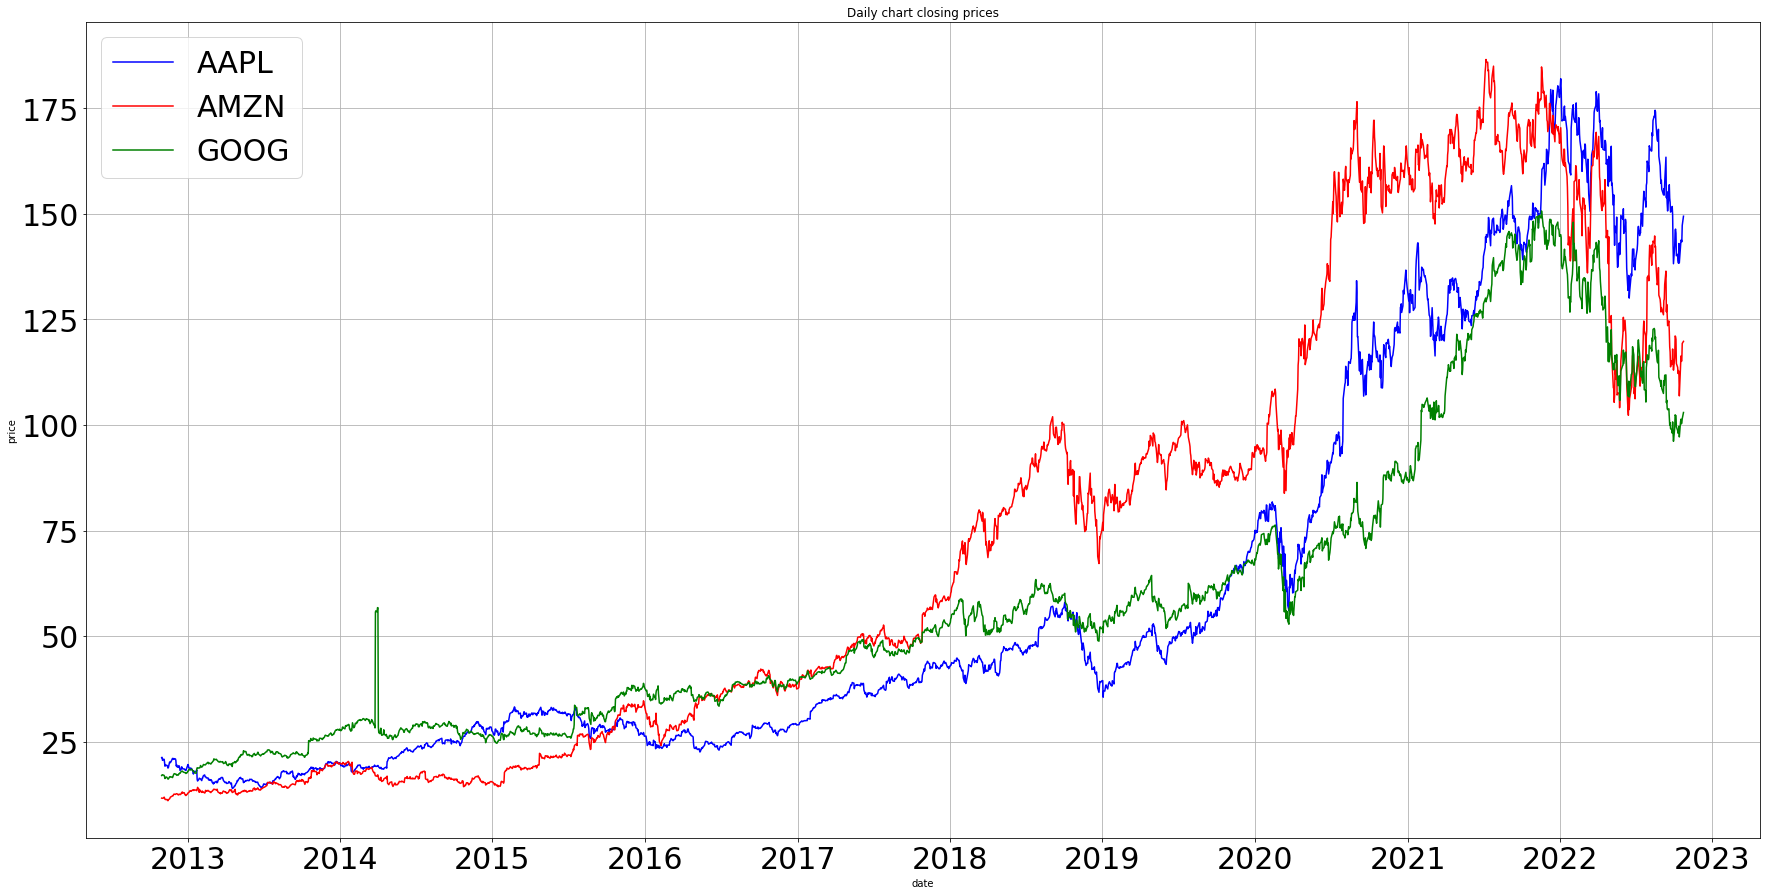

In [255]:
plt.figure(figsize=(30,15))
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)

aapl_daily_chart, = plt.plot(merge_prices["date"], merge_prices["AAPL"], color='blue', label="AAPL")
amzn_daily_chart, = plt.plot(merge_prices["date"], merge_prices["AMZN"], color='red', label="AMZN")
goog_daily_chart, = plt.plot(merge_prices["date"], merge_prices["GOOG"], color='green', label="GOOG")
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily chart closing prices")
plt.legend(fontsize = "30",loc="upper left")

In [256]:
tickers_ratios = pd.DataFrame(columns = ["date", "symbol", 
                                          "period", "priceEarningsRatio", "priceEarningsToGrowthRatio"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/ratios/{name}?period=quarter&limit=43&apikey={prep_key}"
    ratios_response = requests.get(query_url).json()
    tickers_ratio_response = pd.json_normalize(ratios_response)
    tickers_ratio_response["symbol"] = name
    tickers_ratio_response = tickers_ratio_response[["date", "symbol", 
                                          "period", "priceEarningsRatio", "priceEarningsToGrowthRatio"]]
    tickers_ratios= pd.concat([tickers_ratios,tickers_ratio_response])
tickers_ratios.columns=["Date", "Ticker", "Period", "PE", "PEG"]
#print(tickers_ratios)

#Create copy that won't affect original
ticker_ratios = tickers_ratios.copy(deep=True)
#print(fiscal_qbs)

#Create separate dataframe based on symbols
aapl_ratios = ticker_ratios[ticker_ratios["Ticker"] == "AAPL"]
aapl_ratios = pd.DataFrame(aapl_ratios)
aapl_ratios =aapl_ratios.sort_values("Date", ascending=True)

amzn_ratios = ticker_ratios[ticker_ratios["Ticker"] == "AMZN"]
amzn_ratios = pd.DataFrame(amzn_ratios)

goog_ratios = ticker_ratios[ticker_ratios["Ticker"] == "GOOG"]
goog_ratios = pd.DataFrame(goog_ratios)
#goog_ratios.head()
aapl_ratios.tail()

,Date,Ticker,Period,PE,PEG
4,2021-09-25,AAPL,Q4,29.466787,-6.433582
3,2021-12-25,AAPL,Q1,21.339298,0.310164
2,2022-03-26,AAPL,Q2,28.628169,-1.041473
1,2022-06-25,AAPL,Q3,29.441966,-1.365037
0,2022-09-24,AAPL,Q4,29.094279,3.879237


In [312]:
aapl_ratios['Date'] = pd.to_datetime(aapl_ratios['Date'])
merge_prices['date'] = pd.to_datetime(merge_prices['date'])
goog_ratios['Date'] = pd.to_datetime(goog_ratios['Date'])
amzn_ratios['Date'] = pd.to_datetime(amzn_ratios['Date'])

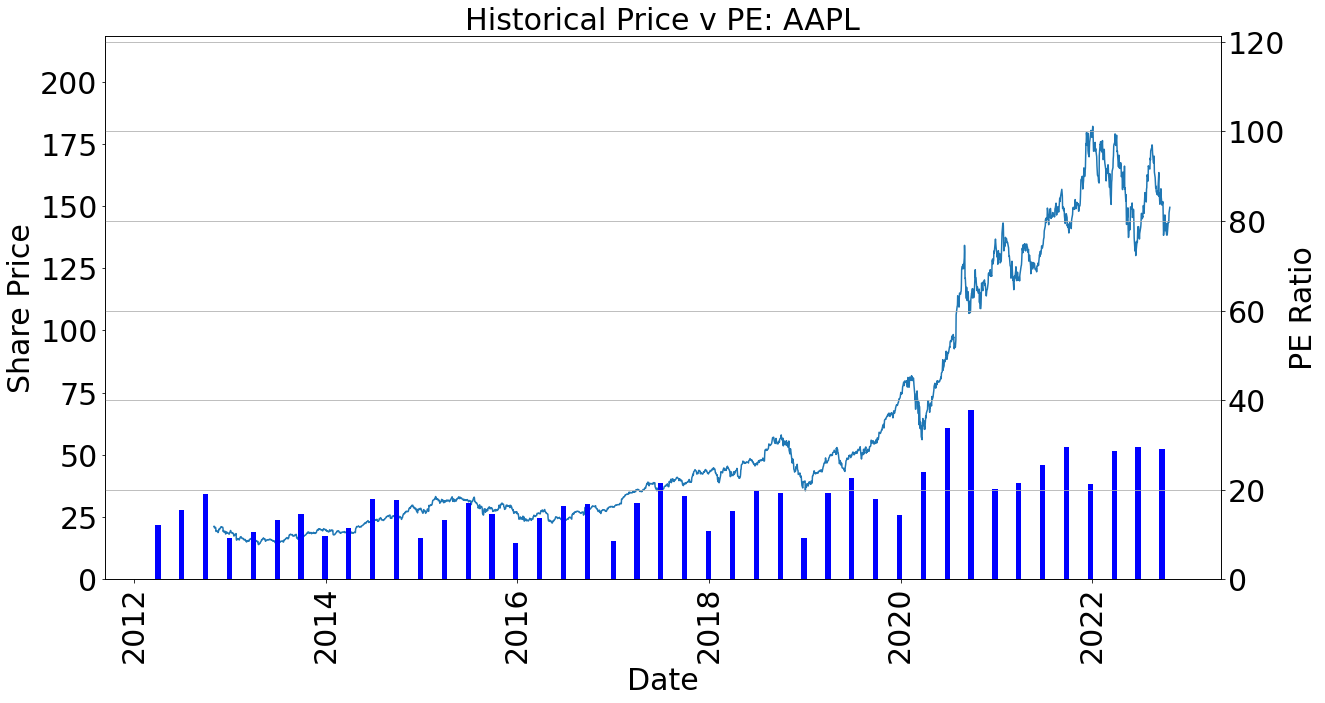

In [308]:
fig = plt.figure(figsize=(20,10))
ax1=plt.subplot(1,1,1)
ax1.plot(merge_prices["date"], merge_prices["AAPL"])
ax1.set_ylim(0,merge_prices["AAPL"].max()*1.2)

for xlabel in ax1.get_xticklabels():
    xlabel.set_rotation(90)
ax2=ax1.twinx()
ax2.bar(aapl_ratios["Date"], aapl_ratios["PE"], width=20, color="b")
ax2.set_ylim(0,merge_prices["AAPL"].max()/1.5)

plt.title("Historical Price v PE: AAPL", fontsize="30")
ax1.set_xlabel("Date", fontsize="30")
ax1.set_ylabel("Share Price", fontsize="30")
ax2.set_ylabel("PE Ratio", fontsize="30")

plt.grid()

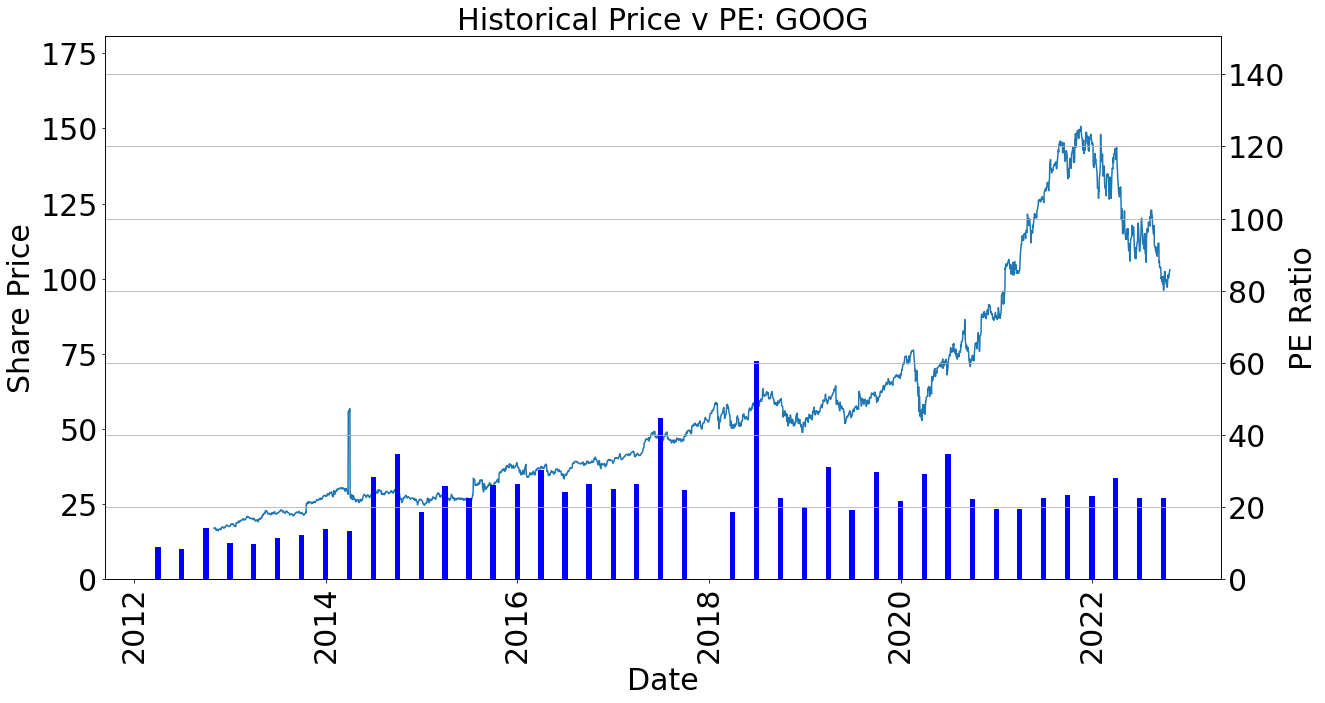

In [311]:
fig = plt.figure(figsize=(20,10))
ax1=plt.subplot(1,1,1)
ax1.plot(merge_prices["date"], merge_prices["GOOG"])
ax1.set_ylim(0,merge_prices["GOOG"].max()*1.2)

for xlabel in ax1.get_xticklabels():
    xlabel.set_rotation(90)
ax2=ax1.twinx()
ax2.bar(goog_ratios["Date"], goog_ratios["PE"], width=20, color="b")
ax2.set_ylim(0,merge_prices["GOOG"].max())

plt.title("Historical Price v PE: GOOG", fontsize="30")
ax1.set_xlabel("Date", fontsize="30")
ax1.set_ylabel("Share Price", fontsize="30")
ax2.set_ylabel("PE Ratio", fontsize="30")

plt.grid()

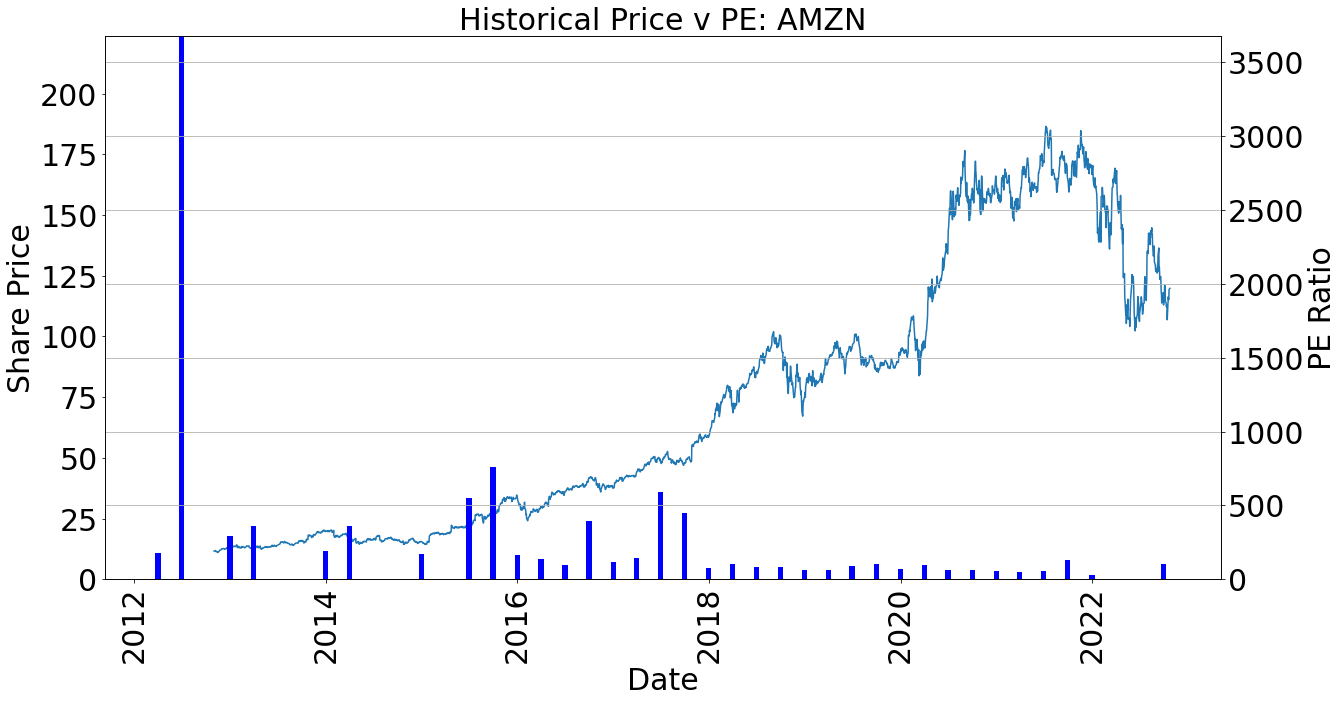

In [314]:
fig = plt.figure(figsize=(20,10))
ax1=plt.subplot(1,1,1)
ax1.plot(merge_prices["date"], merge_prices["AMZN"])
ax1.set_ylim(0,merge_prices["AMZN"].max()*1.2)

for xlabel in ax1.get_xticklabels():
    xlabel.set_rotation(90)
ax2=ax1.twinx()
ax2.bar(amzn_ratios["Date"], amzn_ratios["PE"], width=20, color="b")
ax2.set_ylim(0,amzn_ratios["PE"].max())

plt.title("Historical Price v PE: AMZN", fontsize="30")
ax1.set_xlabel("Date", fontsize="30")
ax1.set_ylabel("Share Price", fontsize="30")
ax2.set_ylabel("PE Ratio", fontsize="30")

plt.grid()